In [182]:
import numpy as np
import cv2
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, concatenate, Lambda
from tensorflow.keras.optimizers import Adam
import pandas as pd
import os

CSV_PATH = "NeoJaundice/chd_jaundice_published_2.csv"
IMG_DIR = "NeoJaundice/images"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        image_data.append(img)
        labels.append(row["blood(mg/dL)"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['patient_id', 'image_idx', 'gender', 'gestational_age', 'age(day)',
       'weight', 'blood(mg/dL)', 'Treatment'],
      dtype='object')
Loaded 2235 images.


In [183]:
def extract_yellow_card(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([23, 41, 133])  
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        yellow_card = img[y:y+h, x:x+w]
        return yellow_card
    else:
        return None  


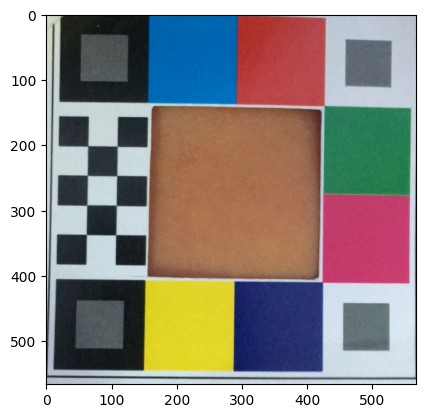

In [200]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image_data[197], cv2.COLOR_BGR2RGB))

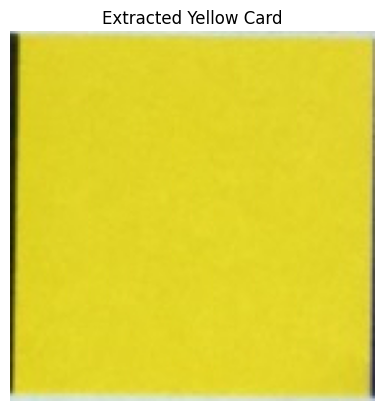

In [199]:
sample_card = extract_yellow_card(image_data[197])
if sample_card is not None:
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(sample_card, cv2.COLOR_BGR2RGB))
    plt.title("Extracted Yellow Card")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not detected in this image.")

In [207]:
def compute_lab_means(lab_img):
    L, A, B = cv2.split(lab_img)
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color(full_img, yellow_card_img):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)
    lab_card = cv2.cvtColor(yellow_card_img, cv2.COLOR_BGR2LAB)
    
    L_card_mean, A_card_mean, B_card_mean = compute_lab_means(lab_card)
    target_L, target_A, target_B = 200.0, 120.0, 207.0  
    
    delta_L = target_L - L_card_mean
    delta_A = target_A - A_card_mean
    delta_B = target_B - B_card_mean
    
    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)
    
    return corrected_bgr


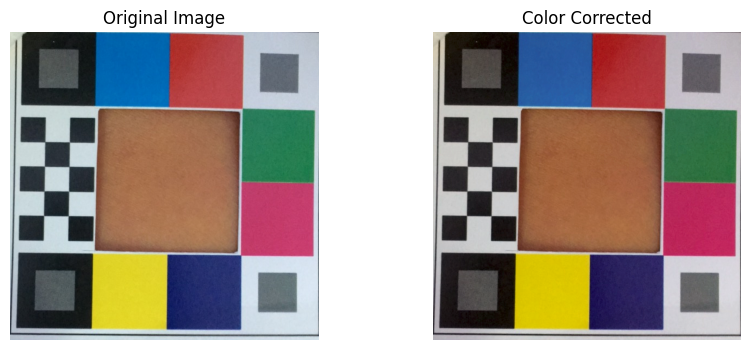

In [208]:
img = image_data[197]
yellow_card = extract_yellow_card(img)
if yellow_card is not None:
    corrected_img = correct_image_color(img, yellow_card)


    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(corrected_img, cv2.COLOR_BGR2RGB))
    plt.title("Color Corrected")
    plt.axis('off')
    plt.show()
else:
    print("Yellow card not found.")


In [210]:
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi


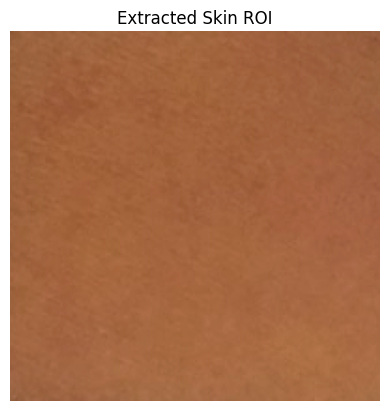

In [211]:
skin_roi = extract_skin_roi(corrected_img)

plt.imshow(cv2.cvtColor(skin_roi, cv2.COLOR_BGR2RGB))
plt.title("Extracted Skin ROI")
plt.axis("off")
plt.show()


In [212]:
import cv2
import numpy as np

def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq


In [213]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    yellow_card = extract_yellow_card(img)
    corrected_img = correct_image_color(img, yellow_card)
    skin_roi = extract_skin_roi(corrected_img)
    return extract_color_spaces(skin_roi)

In [214]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["blood(mg/dL)"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)

print(rgb[0])
print(hsv[0])
print(lab[0])


Processed HSV shape: (2235, 16384, 3)
Processed labels shape: (2235,)
[149 143 169]
[185 129  68]
[139 161  88]


In [215]:
def flatten_for_scaler(data):
    return data.reshape(data.shape[0], -1)

def reshape_for_cnn(data):
    return data.reshape(data.shape[0], 3,16384)

rgb_flat = flatten_for_scaler(processed_rgb)
hsv_flat = flatten_for_scaler(processed_hsv)
ycbcr_flat = flatten_for_scaler(processed_ycbcr)
lab_flat = flatten_for_scaler(processed_lab)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rgb_flat_scaled = scaler.fit_transform(rgb_flat)
hsv_flat_scaled = scaler.fit_transform(hsv_flat)
ycbcr_flat_scaled = scaler.fit_transform(ycbcr_flat)
lab_flat_scaled = scaler.fit_transform(lab_flat)

rgb_scaled = reshape_for_cnn(rgb_flat_scaled)
hsv_scaled = reshape_for_cnn(hsv_flat_scaled)
ycbcr_scaled = reshape_for_cnn(ycbcr_flat_scaled)
lab_scaled = reshape_for_cnn(lab_flat_scaled)

print(rgb_scaled[0])


[[0.15677966 0.35227273 0.39370079 ... 0.62857143 0.11764706 0.25806452]
 [0.6        0.11940299 0.23376623 ... 0.17391304 0.26760563 0.54545455]
 [0.19117647 0.26056338 0.59459459 ... 0.44081633 0.53271028 0.52459016]]


In [216]:
from sklearn.model_selection._split import train_test_split
rgb_train, rgb_temp, hsv_train, hsv_temp, ycbcr_train, ycbcr_temp, lab_train, lab_temp, y_train, y_temp = train_test_split(
    rgb_scaled, hsv_scaled, ycbcr_scaled, lab_scaled, processed_labels, test_size=0.3, random_state=42)

rgb_val,rgb_test,hsv_val, hsv_test, ycbcr_val, ycbcr_test, lab_val, lab_test, y_val, y_test = train_test_split(
    rgb_temp,hsv_temp, ycbcr_temp, lab_temp, y_temp, test_size=0.67, random_state=4)

In [225]:
y_train=y_train/20
y_val=y_val/20


In [222]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, GroupNormalization
from tensorflow.keras.optimizers import Adam

def conv_branch(input_tensor):
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(input_tensor)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2, padding='same')(x)
    x = Flatten()(x)
    return x

def build_rgb_hsv_concat_model(input_shape):
    rgb_input = Input(shape=input_shape, name='rgb_input')
    rgb_features = conv_branch(rgb_input)
    hsv_input = Input(shape=input_shape, name='hsv_input')
    hsv_features = conv_branch(hsv_input)

    combined = Concatenate()([rgb_features, hsv_features])
    
    x = Dense(256, activation='relu')(combined)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='linear')(x)

    model = Model(inputs=[rgb_input, hsv_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model

input_shape = rgb_train.shape[1:]  
model = build_rgb_hsv_concat_model(input_shape)
model.summary()


Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 conv1d_120 (Conv1D)         (None, 3, 32)                1572896   ['rgb_input[0][0]']           
                                                                                                  
 conv1d_124 (Conv1D)         (None, 3, 32)                1572896   ['hsv_input[0][0]']           
                                                                                           

In [223]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
]

history = model.fit(
    [rgb_train, hsv_train], y_train,
    validation_data=([rgb_val, hsv_val], y_val),
    epochs=150,
    batch_size=32,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/150
49/49 [==============================] - 5s 76ms/step - loss: 0.1100 - mae: 0.2662 - val_loss: 0.0643 - val_mae: 0.2105 - lr: 1.0000e-04
Epoch 2/150
49/49 [==============================] - 3s 68ms/step - loss: 0.0732 - mae: 0.2202 - val_loss: 0.0520 - val_mae: 0.1863 - lr: 1.0000e-04
Epoch 3/150
49/49 [==============================] - 3s 65ms/step - loss: 0.0652 - mae: 0.2065 - val_loss: 0.0479 - val_mae: 0.1771 - lr: 1.0000e-04
Epoch 4/150
49/49 [==============================] - 3s 56ms/step - loss: 0.0604 - mae: 0.1990 - val_loss: 0.0483 - val_mae: 0.1780 - lr: 1.0000e-04
Epoch 5/150
49/49 [==============================] - 3s 61ms/step - loss: 0.0585 - mae: 0.1938 - val_loss: 0.0490 - val_mae: 0.1802 - lr: 1.0000e-04
Epoch 6/150
49/49 [==============================] - 3s 59ms/step - loss: 0.0562 - mae: 0.1885 - val_loss: 0.0640 - val_mae: 0.2078 - lr: 1.0000e-04
Epoch 7/150
49/49 [==============================] - 3s 64ms/step - loss: 0.0591 - mae: 0.1926 - val_loss:

In [227]:
test_loss, test_mae = model.evaluate([rgb_test, hsv_test], y_test, verbose=2)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict([rgb_test, hsv_test])
y_pred=y_pred*20
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

15/15 - 0s - loss: 141.1223 - mae: 10.6922 - 223ms/epoch - 15ms/step
Test Loss (MSE): 141.1223
Test MAE: 10.6922
15/15 [==============================] - 0s 13ms/step
RMSE: 3.899
R²: 0.459


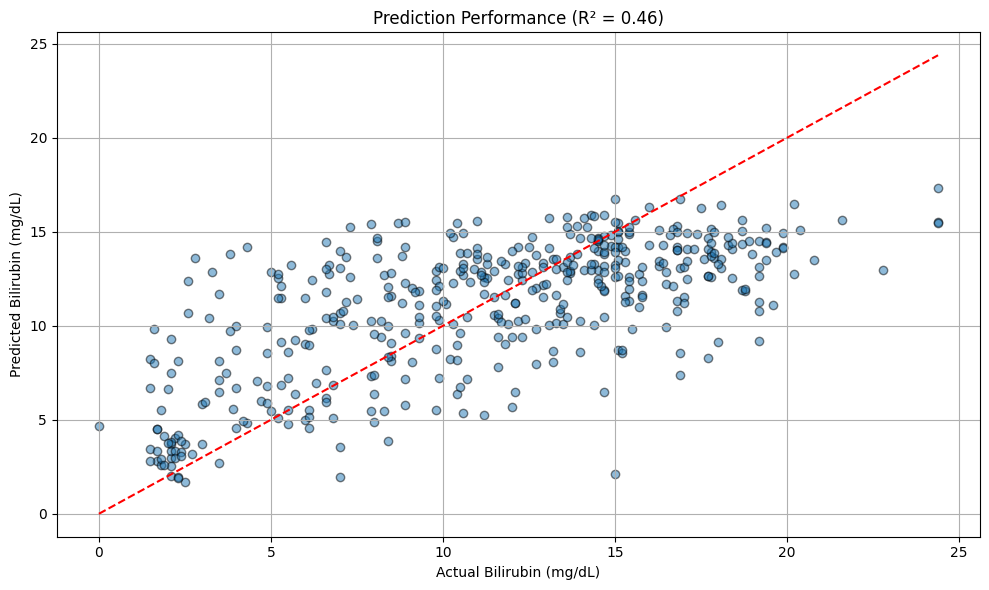

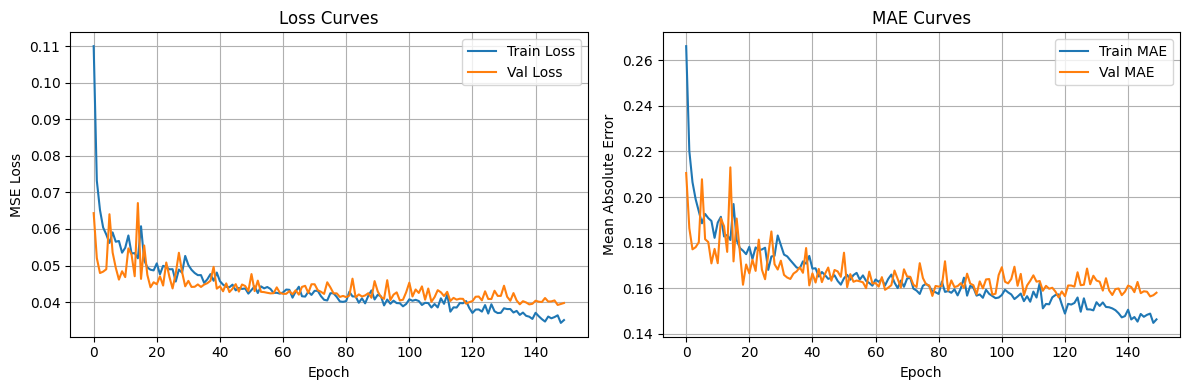

In [228]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Curves')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
